In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.datasets import make_classification

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KernelDensity

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from scipy.stats import norm

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
colors = np.array(["red", "green","blue"])
regions_colors = np.array(["pink","lightgreen","lightskyblue"])

%matplotlib inline


In [4]:
# Function that cuts 2.5% on each side of values field
def prep(column):
    q1 = column.quantile(q=0.025)
    q2 = column.quantile(q=0.975)
    m = column.median()

    result = column.apply(lambda x: x if q1 <= x <= q2 else m)

    return result


# Function to use prep() on multiple columns
def multiprep(data, column_list):
    for col in column_list:
        data[col] = prep(data[col])


def silverman_bandwidth(X):
    """
    Функция для вычисления ширины окна Сильвермана.

    Параметры:
        X (numpy.array): Матрица признаков. Каждая строка - это один объект, каждый столбец - признак.

    Возвращает:
        float: Значение ширины окна Сильвермана.
    """
    d = X.shape[1]
    n = X.shape[0]
    sigma = np.std(X)

    if d == 1:
        return (4 / (d + 2)) ** (1 / (d + 4)) * sigma

    return (
        (4 / (d + 2)) ** (1 / (d + 4))
        * np.linalg.det(np.cov(X.T)) ** (1 / (2 * d))
        * n ** (-1 / (d + 4))
    )

In [5]:
# Instead of using the ready-made scikit-learn library functions,
# which are often terribly adapted to multiclass classification,
# I wrote the classifier myself.
# I hope this will be taken into account when evaluating the work.
# Well, or at least there will be some respect.
# Thanks. Copyright TAB.fffgson


class KernelDensityClassifier:
    """
    A nonparametric Bayesian classifier.
    Uses the nuclear density method.
    I tried to fit all the functions that I used in my work here.
    If something did not work out, then it is in the block above.
    Otherwise, the classifier is designed for classification tasks, and it can work not only with normalized data.
    Also, he doesn't care about the number of classes (at least, I plan on it).
    But what I can say for sure is that he will cope with grades 3 with a bang.
    I will try to describe each function in as much detail as possible.
    Let me know if you find errors, flaws, or places where you can optimize the code (TG: @fffgson).
    Good luck using it.

    WARNING!!!

        /// IF YOU WANT CLASSIFIER TO WORK PROPERLY
        /// IMPORT EVERY LIBRARY FROM THE FIRST BLOCK

    A bit of information about the classifier:
        By defaults: uses Gaussian kernel and Silverman bandwidth.
        Your can (and you should) change them as you like.
    """

    def __init__(self, kernel="gaussian", bandwidth="silverman"):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.models = []

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        for cls in self.classes:
            # Uses sklearn KernelDensity fucntion to train
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth).fit(
                X_train[y_train == cls]
            )
            self.models.append(kde)

    def predict(self, X):
        scores = []
        for model in self.models:
            score = model.score_samples(X)
            scores.append(score)
        scores = np.array(scores)
        return np.argmax(scores, axis=0)

    def predict_proba(self, X):
        class_scores = []
        for model in self.models:
            score = model.score_samples(X)
            class_scores.append(score)
        class_scores = np.array(class_scores)
        probs = np.exp(class_scores) / np.sum(np.exp(class_scores), axis=0)
        return probs.T

    def generate_binary_data(self, num_samples=100, num_features=2, random_state=42):
        X, y = make_classification(
            n_samples=num_samples,
            n_features=num_features,
            n_redundant=0,
            n_informative=2,
            n_clusters_per_class=1,
            n_classes=2,
            random_state=random_state,
        )
        print(">>> Binary data created.")
        print(f">>> The dimension of the data array: {X.shape[0]} x {X.shape[1]}")
        print(f">>> The dimension of the labels array: {y.shape[0]}")
        return X, y

    def generate_multiclass_data(
        self, num_samples=100, num_features=2, num_classes=3, random_state=42
    ):
        X, y = make_classification(
            n_samples=num_samples,
            n_features=num_features,
            n_redundant=0,
            n_informative=2,
            n_clusters_per_class=1,
            n_classes=num_classes,
            random_state=random_state,
        )
        print(">>> Multiclass data created.")
        print(f">>> The dimension of the data array: {X.shape[0]} x {X.shape[1]}")
        print(f">>> The dimension of the labels array: {y.shape[0]}")
        return X, y

**>>> TASK 1**

In [6]:
# Generating data

num_samples_per_class = 100
num_samples = 500
num_classes = 3
num_features = 2

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_features,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=num_classes,
    random_state=42,
)

print(f">>> The dimension of the data array: {X.shape[0]} x {X.shape[1]}")
print(f">>> The dimension of the array of class labels: {y.shape[0]}")

>>> The dimension of the data array: 500 x 2
>>> The dimension of the array of class labels: 500


In [7]:
# Dataframe for convenience
data = pd.DataFrame(X)
labels = pd.DataFrame(y)
df = pd.merge(data, labels, left_index=True, right_index=True)
df = df.rename(columns={"0_x": "f1", 1: "f2", "0_y": "class"})
df.head()

,f1,f2,class
0,1.027917,1.082279,1
1,1.406849,-1.378083,0
2,1.519133,1.356495,1
3,-0.836896,-1.185549,2
4,-1.649242,-0.241277,2


In [8]:
# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**>>> TASK 2**

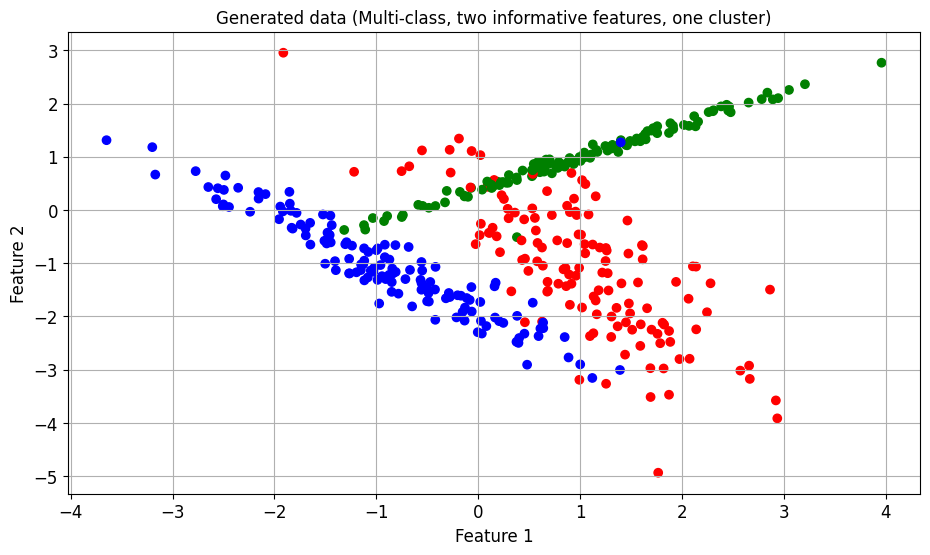

In [9]:
# Plot data
colors = np.array(["red", "green", "blue"])
# sns.set(style="whitegrid")
plt.title("Generated data (Multi-class, two informative features, one cluster)")
plt.scatter(X_train[:, 0], X_train[:, 1], c=colors[y_train])
# plt.xlim([-3.5,5])
# plt.ylim([-5,2.5])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.savefig("4.jpg")
plt.show()

<Figure size 1100x600 with 0 Axes>

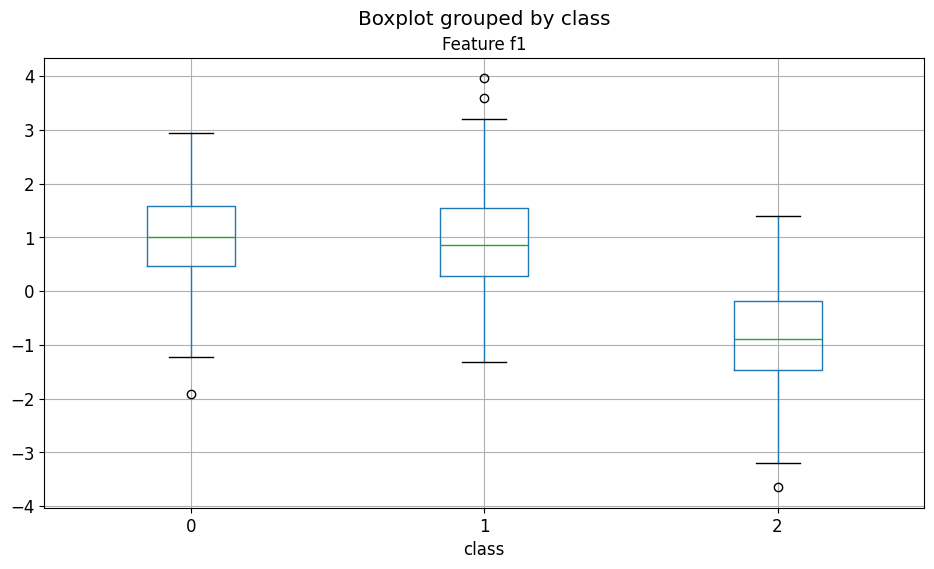

<Figure size 1100x600 with 0 Axes>

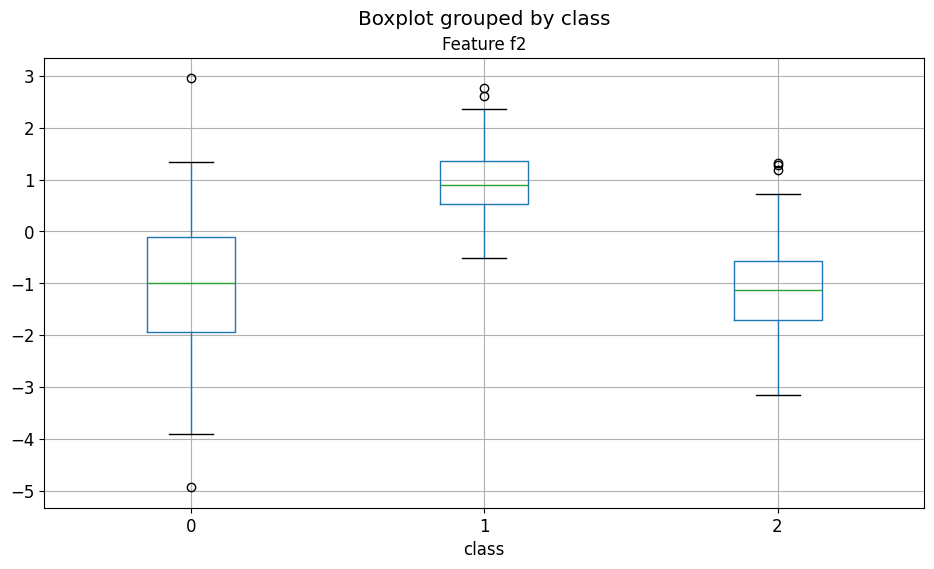

In [10]:
# Boxplots
for col in df.columns[:-1]:
    plt.figure()
    df.boxplot(col, by="class")
    plt.title(f"Feature {col}")
    plt.grid(True)
    plt.show()

**>>> TASK 3 DROPPED BEACAUSE DATA IS SYNTHETIC**

**>>> TASK 4**

**>>> TASK 4.1**

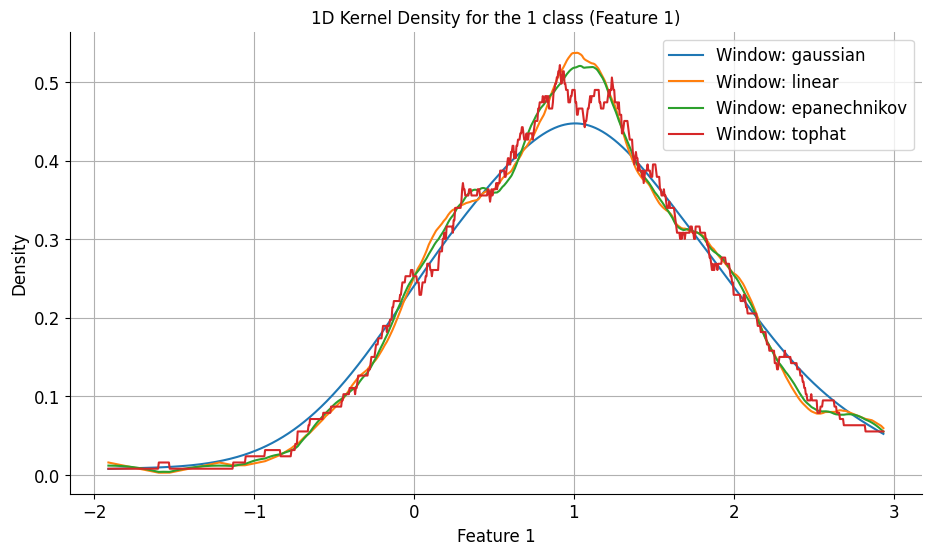

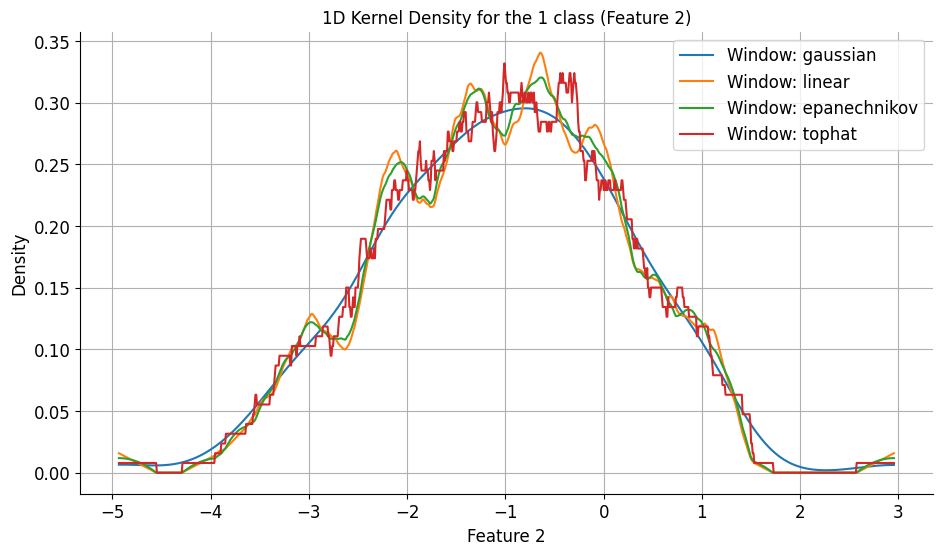

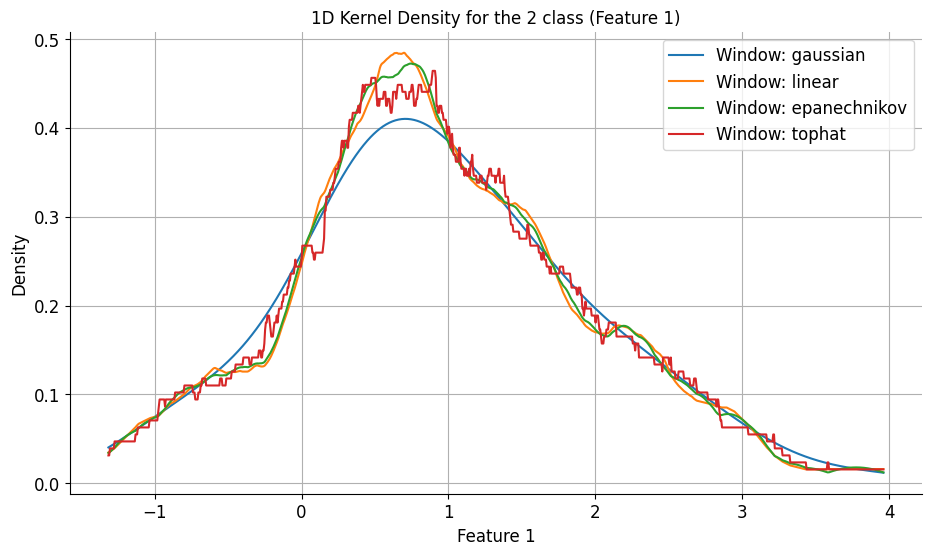

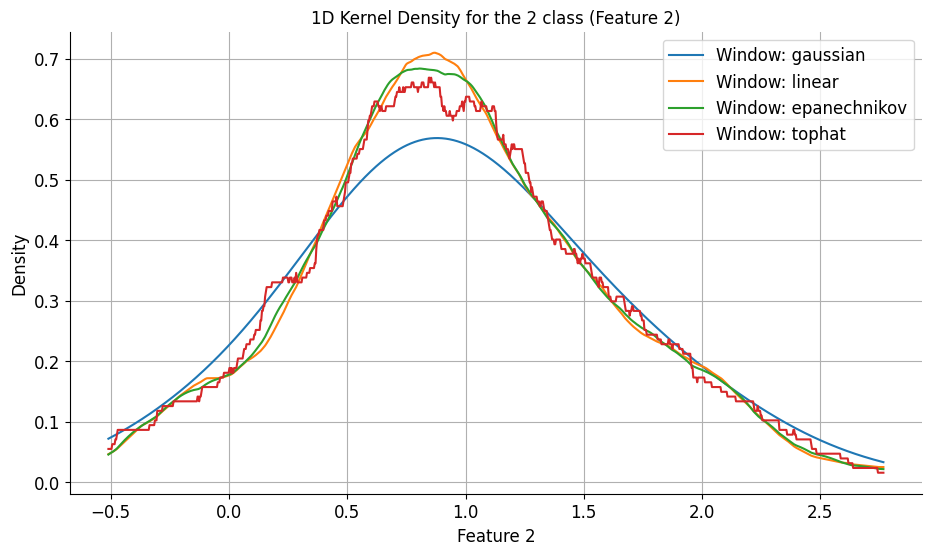

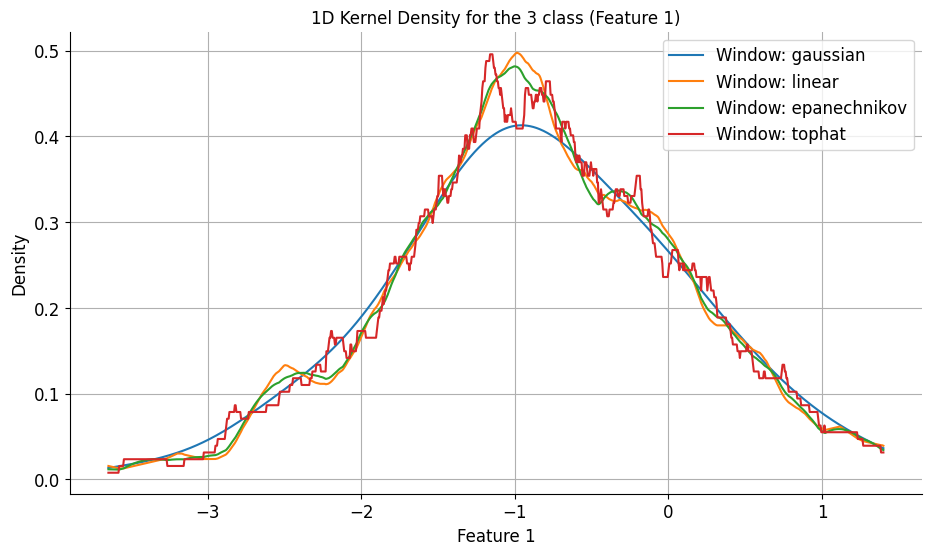

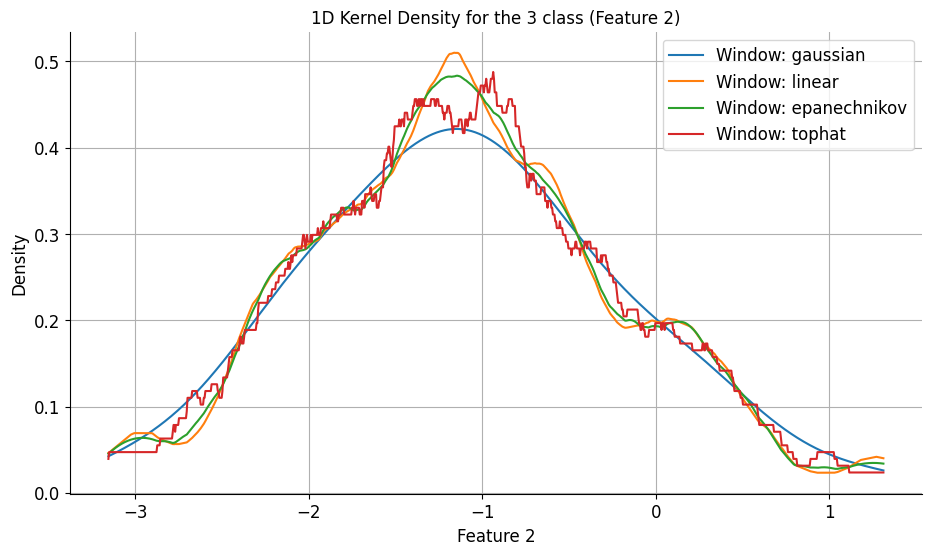

In [11]:
# Graphs of the reconstructed one-dimensional
# distribution densities of each feature for each class
windows = ["gaussian", "linear", "epanechnikov", "tophat"]
for cls in range(3):
    for ft in range(2):
        # Converting a vector to a matrix
        X_cls = X[y == cls, ft].reshape(-1, 1)
        for wnd in windows:
            kde = KernelDensity(bandwidth="silverman", kernel=wnd)

            kde.fit(X_cls)

            x = np.linspace(min(X_cls), max(X_cls), 1000)
            log_density = kde.score_samples(x)
            density = np.exp(log_density)

            # Building a KDE plot for the current feature with the current window
            plt.plot(x, density, label=f"Window: {wnd}")
        plt.title(f"1D Kernel Density for the {cls + 1} class (Feature {ft + 1})")
        plt.xlabel(f"Feature {ft + 1}")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        sns.despine()
        plt.show()

**>>> TASK 4.2**

In [12]:
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print(
    f">>> Accuracy on GaussianNB >>> Avg: {scores.mean().round(2)} >>> STD: {scores.std().round(4)}"
)

NameError: name 'model' is not defined

In [ ]:
windows = ["gaussian", "linear", "epanechnikov", "tophat"]
n_splits = 5
kf = KFold(n_splits=n_splits)

for wd in windows:
    accuracies_train = []
    accuracies_test = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        classifier = KernelDensityClassifier(kernel=wd)
        classifier.fit(X_train_fold, y_train_fold)

        y_train_pred = classifier.predict(X_train_fold)
        y_test_pred = classifier.predict(X_test_fold)

        acc_train = np.sum(y_train_pred == y_train_fold) / len(y_train_fold)
        acc_test = np.sum(y_test_pred == y_test_fold) / len(y_test_fold)

        accuracies_train.append(acc_train)
        accuracies_test.append(acc_test)

    mean_acc_train = np.mean(accuracies_train)
    std_acc_train = np.std(accuracies_train)

    mean_acc_test = np.mean(accuracies_test)
    std_acc_test = np.std(accuracies_test)

    print(
        f">>> (Window: {wd}) >>> Mean accuracy on training set: {mean_acc_train.round(2)} >>> Standard deviation: {std_acc_train.round(5)}"
    )
    print(
        f">>> (Window: {wd}) >>> Mean accuracy on test set: {mean_acc_test.round(2)} >>> Standard deviation: {std_acc_test.round(5)}"
    )

>>> (Window: gaussian) >>> Mean accuracy on training set: 0.92 >>> Standard deviation: 0.00893
>>> (Window: gaussian) >>> Mean accuracy on test set: 0.91 >>> Standard deviation: 0.01871
>>> (Window: linear) >>> Mean accuracy on training set: 0.96 >>> Standard deviation: 0.00424
>>> (Window: linear) >>> Mean accuracy on test set: 0.94 >>> Standard deviation: 0.02291
>>> (Window: epanechnikov) >>> Mean accuracy on training set: 0.96 >>> Standard deviation: 0.00523
>>> (Window: epanechnikov) >>> Mean accuracy on test set: 0.94 >>> Standard deviation: 0.02291
>>> (Window: tophat) >>> Mean accuracy on training set: 0.95 >>> Standard deviation: 0.00625
>>> (Window: tophat) >>> Mean accuracy on test set: 0.92 >>> Standard deviation: 0.02894


**>>> TASK 4.3**


        >>> Max value of mean accuracy for train set:
        >>> Window type: gaussian
        >>> Value: 1.0
        >>> Index: [0 1 2 3]
        >>> Value of bandwidth: [0.00502513 0.01005025 0.01507538 0.0201005 ]

        >>> Max value of mean accuracy for test set:
        >>> Window type: gaussian
        >>> Value: 0.9475
        >>> Index: [31 32]
        >>> Value of bandwidth: [0.16080402 0.16582915]


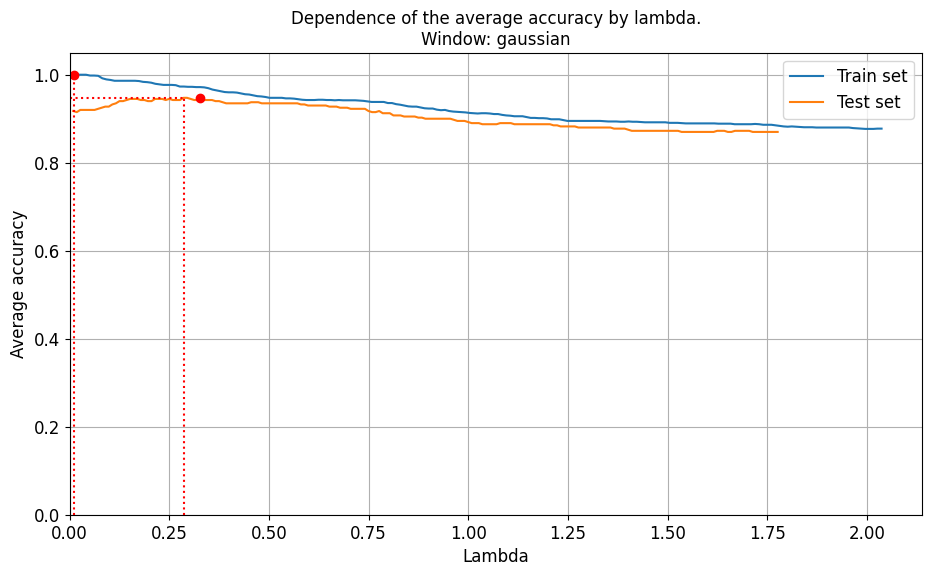

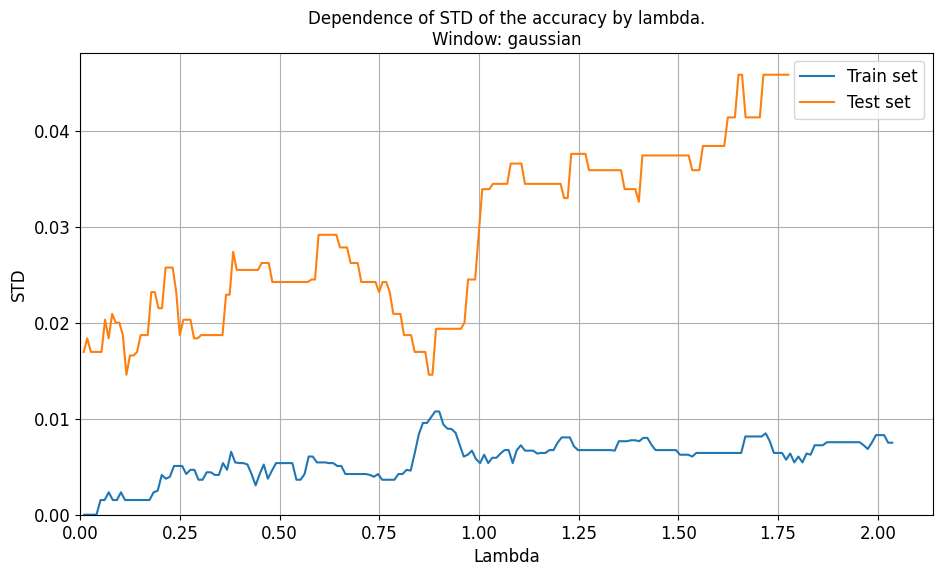


        >>> Max value of mean accuracy for train set:
        >>> Window type: linear
        >>> Value: 1.0
        >>> Index: [0 1 2 3 4 5 6 7 8 9]
        >>> Value of bandwidth: [0.00502513 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126]

        >>> Max value of mean accuracy for test set:
        >>> Window type: linear
        >>> Value: 0.9375
        >>> Index: [57]
        >>> Value of bandwidth: [0.29145729]


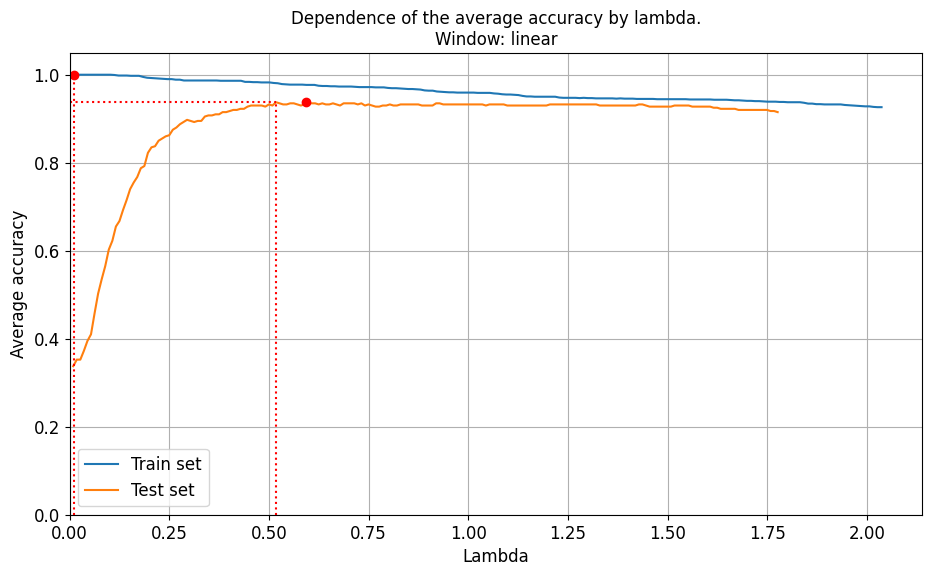

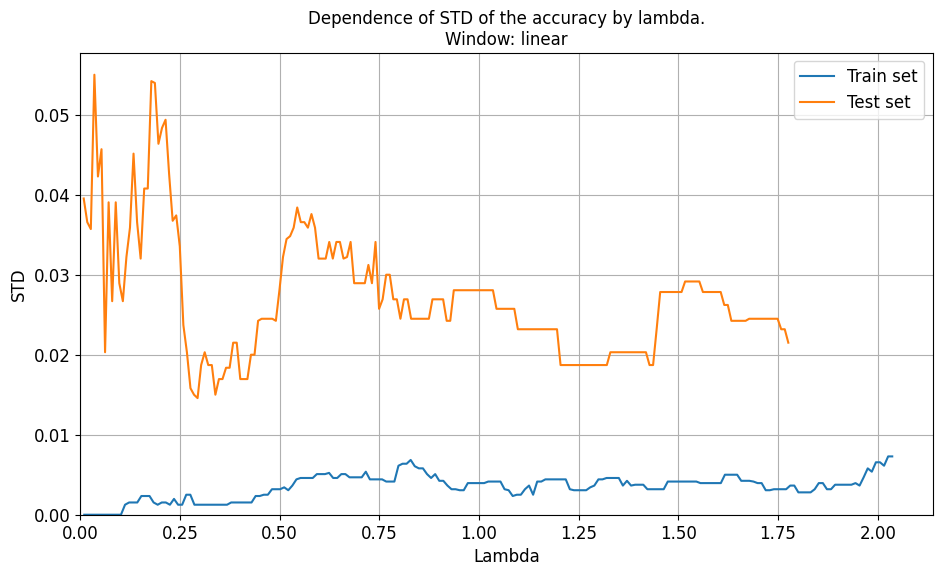


        >>> Max value of mean accuracy for train set:
        >>> Window type: epanechnikov
        >>> Value: 1.0
        >>> Index: [0 1 2 3 4 5 6]
        >>> Value of bandwidth: [0.00502513 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588]

        >>> Max value of mean accuracy for test set:
        >>> Window type: epanechnikov
        >>> Value: 0.9375
        >>> Index: [57 58]
        >>> Value of bandwidth: [0.29145729 0.29648241]


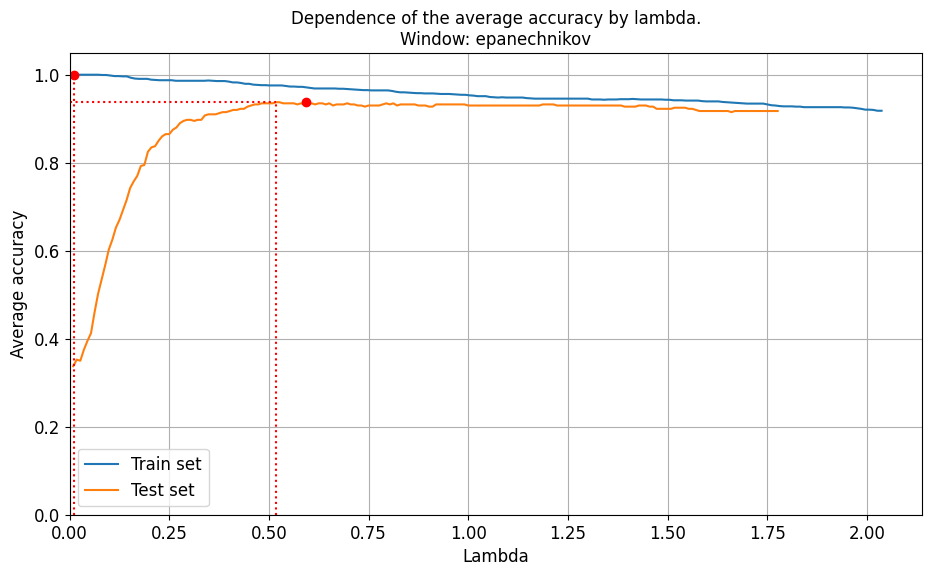

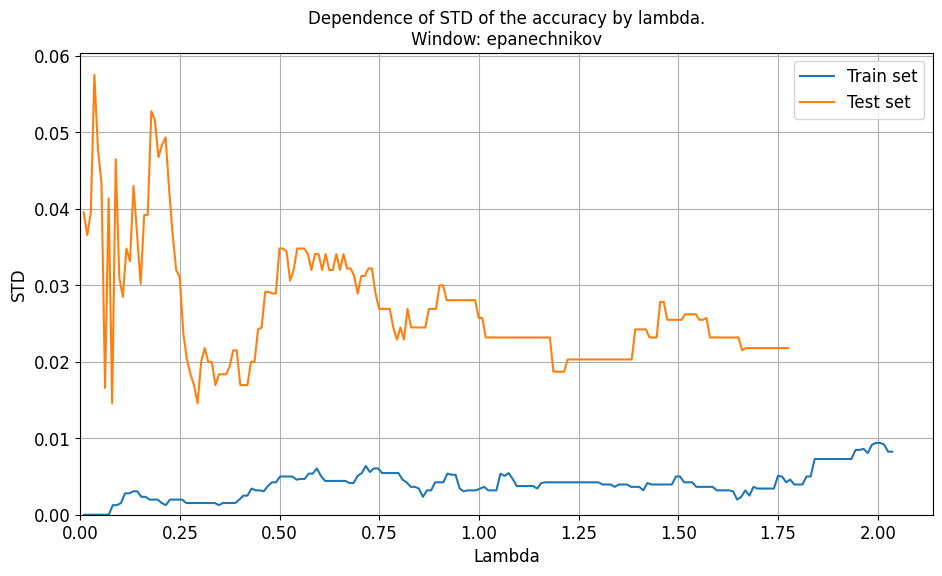


        >>> Max value of mean accuracy for train set:
        >>> Window type: tophat
        >>> Value: 1.0
        >>> Index: [0 1]
        >>> Value of bandwidth: [0.00502513 0.01005025]

        >>> Max value of mean accuracy for test set:
        >>> Window type: tophat
        >>> Value: 0.9399999999999998
        >>> Index: [55 56 57]
        >>> Value of bandwidth: [0.28140704 0.28643216 0.29145729]


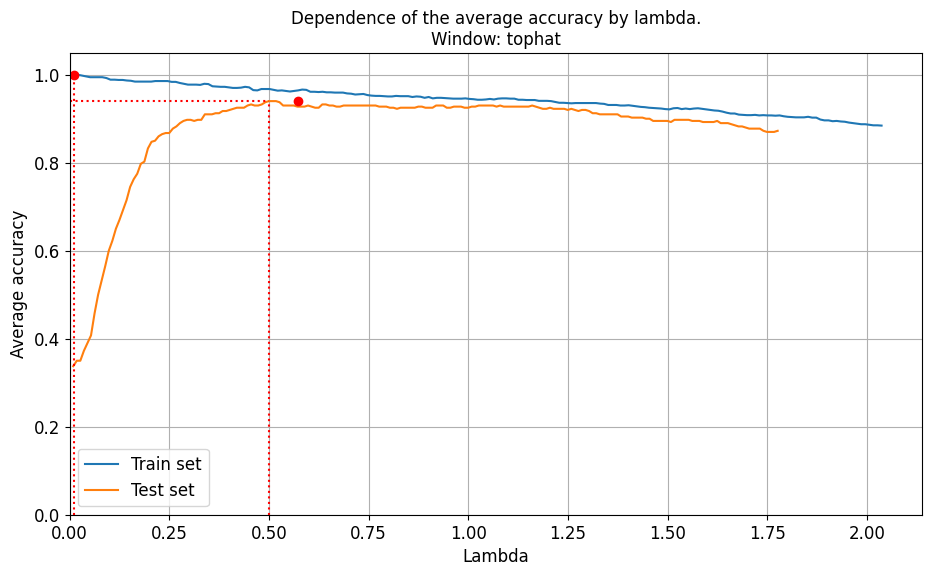

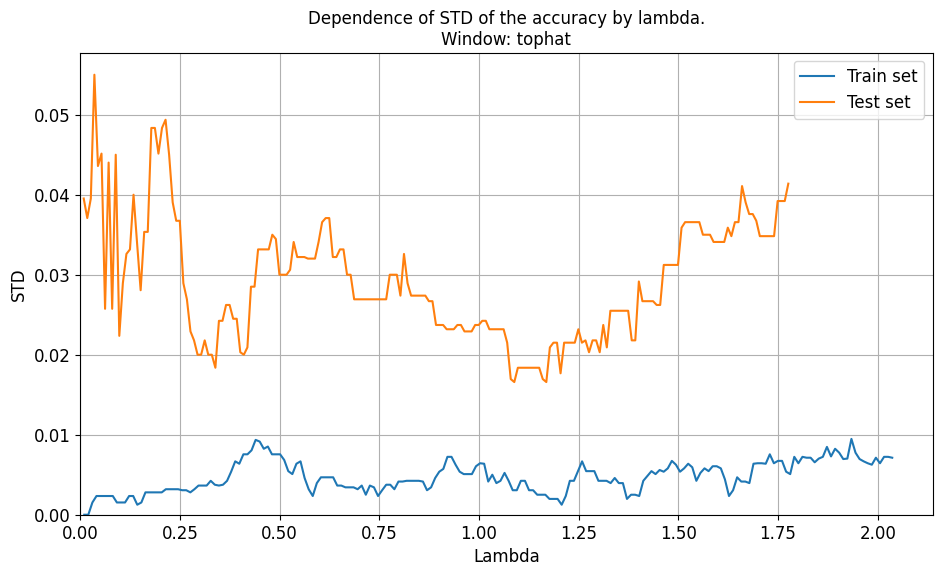

In [ ]:
windows = ["gaussian", "linear", "epanechnikov", "tophat"]
n_splits = 5
kf = KFold(n_splits=n_splits)

bandwidth_values = np.linspace(0.0, 1.0, 200)[1:]

silverman_bandwidth_train = silverman_bandwidth(X_train)
silverman_bandwidth_test = silverman_bandwidth(X_test)

for wd in windows:
    lambda_list_train = []
    lambda_list_test = []

    acc_mean_list_train = []
    acc_mean_list_test = []

    acc_std_list_train = []
    acc_std_list_test = []

    for val in bandwidth_values:
        accuracies_train = []
        accuracies_test = []
        lambda_coeff_train = val / silverman_bandwidth_train
        lambda_coeff_test = val / silverman_bandwidth_test

        lambda_list_train.append(lambda_coeff_train)
        lambda_list_test.append(lambda_coeff_test)

        for train_index, test_index in kf.split(X_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            classifier = KernelDensityClassifier(kernel=wd, bandwidth=val)
            classifier.fit(X_train_fold, y_train_fold)

            y_train_pred = classifier.predict(X_train_fold)
            y_test_pred = classifier.predict(X_test_fold)

            acc_train = np.sum(y_train_pred == y_train_fold) / len(y_train_fold)
            acc_test = np.sum(y_test_pred == y_test_fold) / len(y_test_fold)

            accuracies_train.append(acc_train)
            accuracies_test.append(acc_test)

        mean_acc_train = np.mean(accuracies_train)
        std_acc_train = np.std(accuracies_train)

        mean_acc_test = np.mean(accuracies_test)
        std_acc_test = np.std(accuracies_test)

        acc_mean_list_train.append(mean_acc_train)
        acc_mean_list_test.append(mean_acc_test)

        acc_std_list_train.append(std_acc_train)
        acc_std_list_test.append(std_acc_test)

    lambda_list_train = np.array(lambda_list_train)
    lambda_list_test = np.array(lambda_list_test)

    acc_mean_list_train = np.array(acc_mean_list_train)
    acc_mean_list_test = np.array(acc_mean_list_test)

    acc_std_list_train = np.array(acc_std_list_train)
    acc_std_list_test = np.array(acc_std_list_test)

    max_mean_acc_train = max(acc_mean_list_train)
    max_mean_acc_test = max(acc_mean_list_test)

    idx_max_mean_acc_train = np.where(acc_mean_list_train == max_mean_acc_train)[0]
    idx_max_mean_acc_test = np.where(acc_mean_list_test == max_mean_acc_test)[0]

    print(
        f"""
        >>> Max value of mean accuracy for train set:
        >>> Window type: {wd}
        >>> Value: {max_mean_acc_train}
        >>> Index: {idx_max_mean_acc_train}
        >>> Value of bandwidth: {bandwidth_values[idx_max_mean_acc_train]}"""
    )
    print(
        f"""
        >>> Max value of mean accuracy for test set:
        >>> Window type: {wd}
        >>> Value: {max_mean_acc_test}
        >>> Index: {idx_max_mean_acc_test}
        >>> Value of bandwidth: {bandwidth_values[idx_max_mean_acc_test]}"""
    )

    plt.figure()

    # Main plots
    plt.plot(lambda_list_train, acc_mean_list_train, label="Train set")
    plt.plot(lambda_list_test, acc_mean_list_test, label="Test set")

    # Vertical lines to indicate the position of max point
    plt.plot(
        [
            lambda_list_train[idx_max_mean_acc_train][0],
            lambda_list_train[idx_max_mean_acc_train][0],
        ],
        [0.0, max_mean_acc_train],
        "r:",
    )
    plt.plot(
        [
            lambda_list_test[idx_max_mean_acc_test][0],
            lambda_list_test[idx_max_mean_acc_test][0],
        ],
        [0.0, max_mean_acc_test],
        "r:",
    )

    # Horyzontal lines to indicate the position of max point
    plt.plot(
        [0, lambda_list_train[idx_max_mean_acc_train][0]],
        [max_mean_acc_train, max_mean_acc_train],
        "r:",
    )
    plt.plot(
        [0, lambda_list_test[idx_max_mean_acc_test][0]],
        [max_mean_acc_test, max_mean_acc_test],
        "r:",
    )

    # Dots in max points
    plt.plot([lambda_list_train[idx_max_mean_acc_train][0]], [max_mean_acc_train], "ro")
    plt.plot([lambda_list_train[idx_max_mean_acc_test][0]], [max_mean_acc_test], "ro")

    # Additional parameters
    plt.title(f"Dependence of the average accuracy by lambda.\nWindow: {wd}")
    plt.xlabel("Lambda")
    plt.ylabel("Average accuracy")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(lambda_list_train, acc_std_list_train, label="Train set")
    plt.plot(lambda_list_test, acc_std_list_test, label="Test set")
    plt.title(f"Dependence of STD of the accuracy by lambda.\nWindow: {wd}")
    plt.xlabel("Lambda")
    plt.ylabel("STD")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

**>>> TASK 4.4**

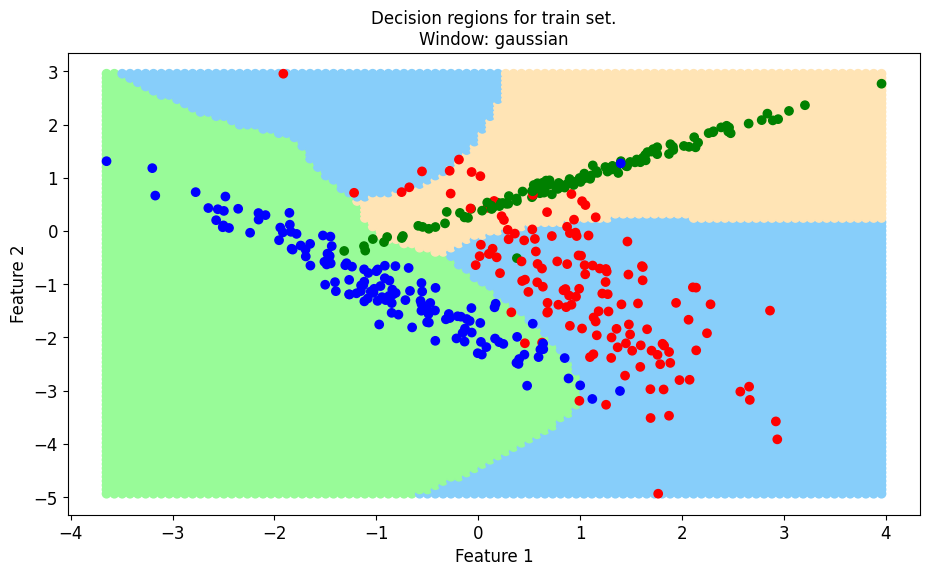

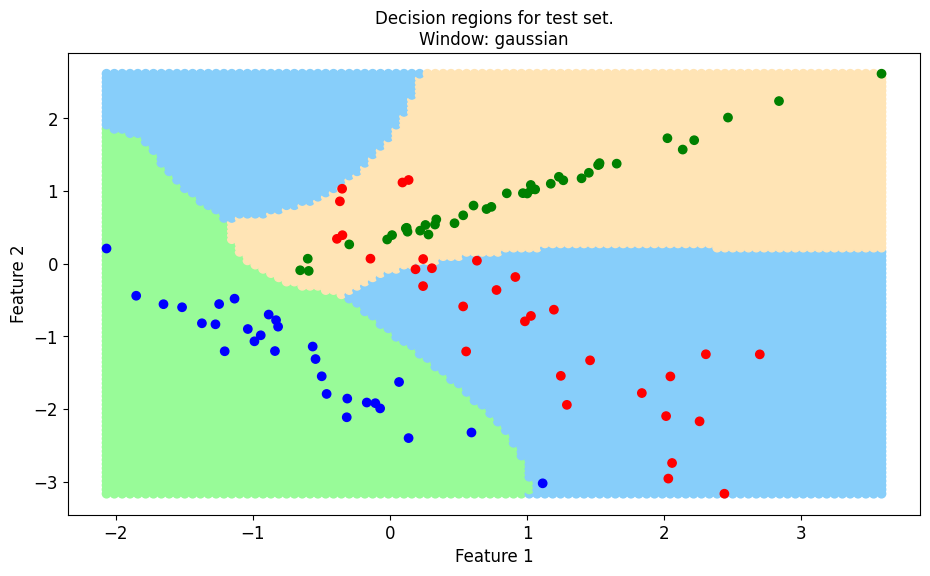

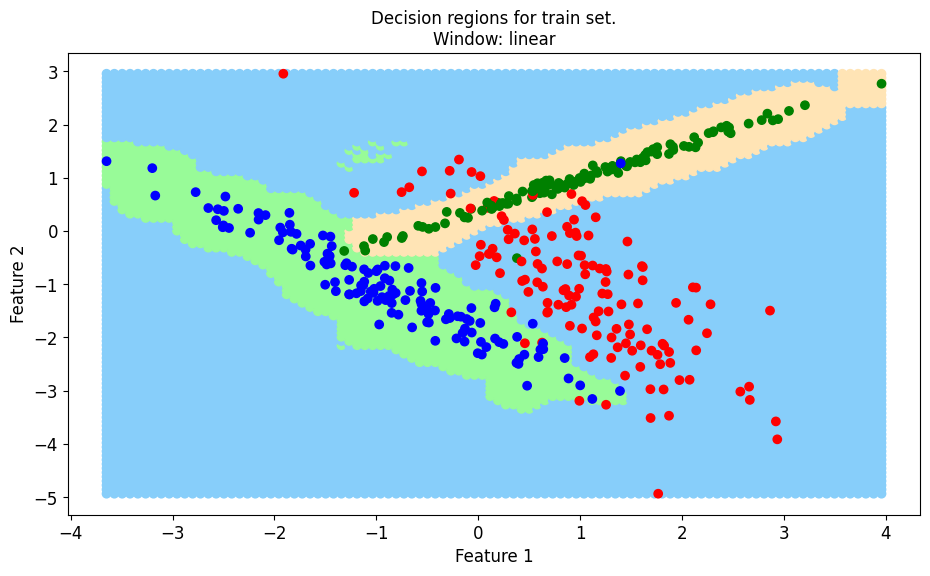

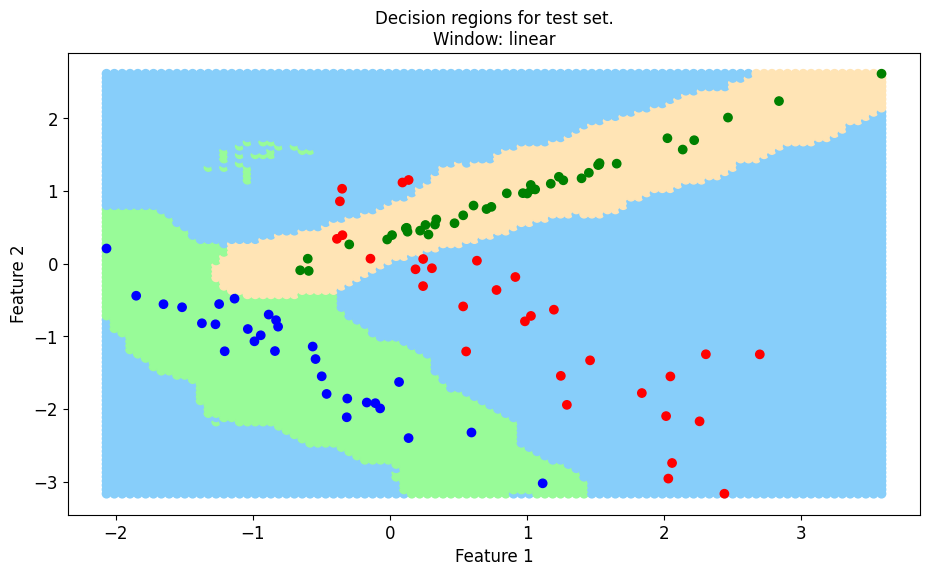

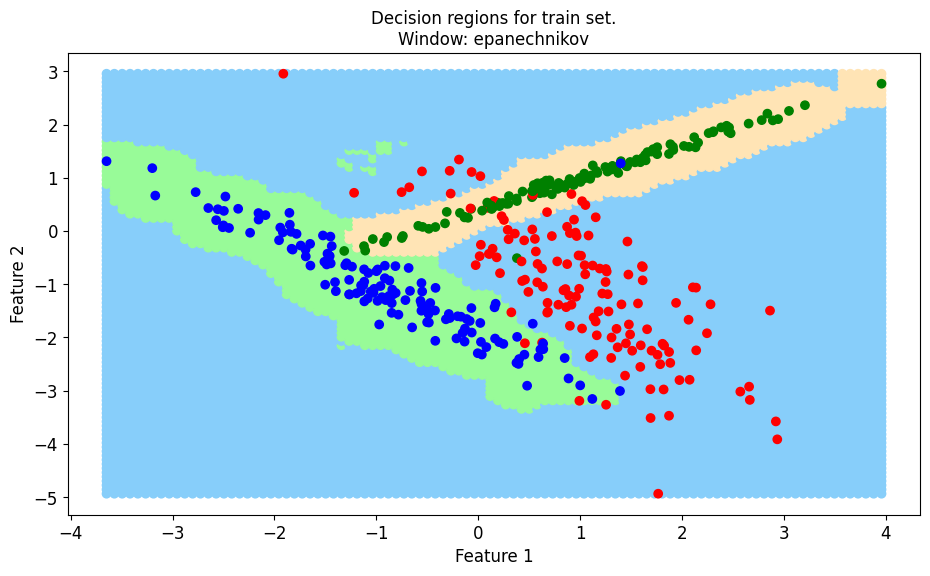

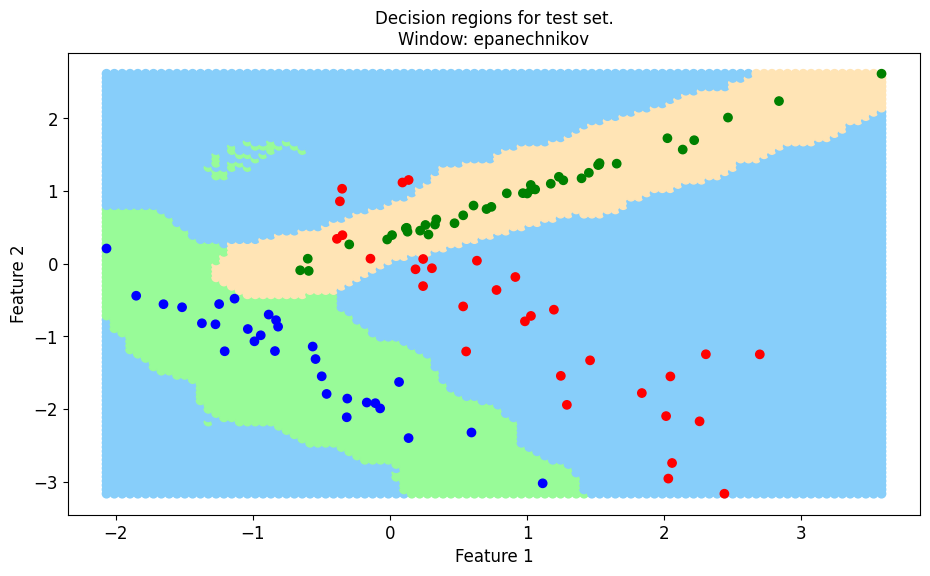

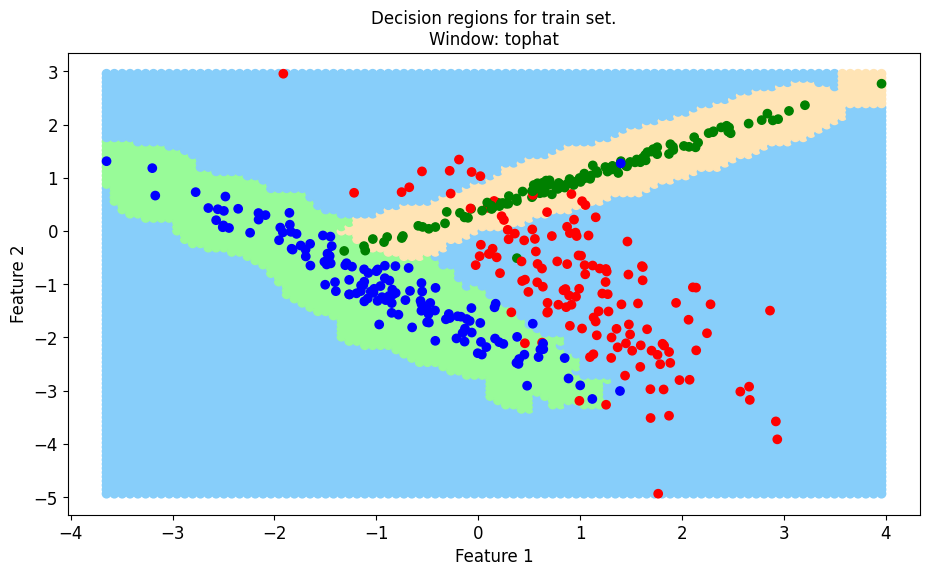

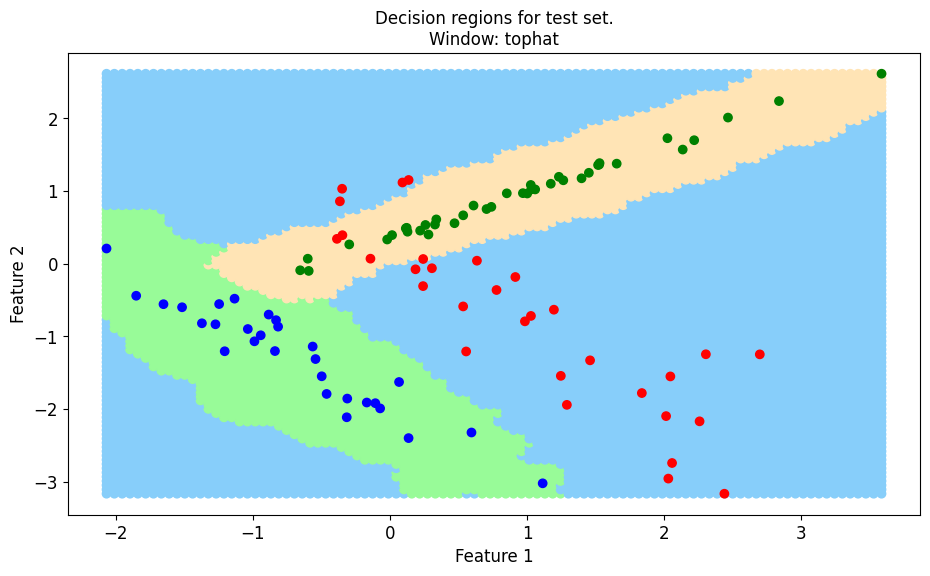

In [ ]:
def colorisation(array):
    color_array = []
    for item in array:
        if item == 0:
            color_array.append("pink")
        elif item == 1:
            color_array.append("yellow")
        else:
            color_array.append("lightgreen")
    return color_array


windows = ["gaussian", "linear", "epanechnikov", "tophat"]
n_point = 100

colors_train = colorisation(y_train)
colors_test = colorisation(y_test)

for wd in windows:
    classifier = KernelDensityClassifier(kernel=wd, bandwidth="silverman")
    classifier.fit(X_train, y_train)

    m = np.meshgrid(
        np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), n_point),
        np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), n_point),
    )
    m_labels = classifier.predict(np.vstack((np.ravel(m[0]), np.ravel(m[1]))).T)

    plt.scatter(m[0], m[1], c=regions_colors[m_labels])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=colors[y_train])
    plt.title(f"Decision regions for train set.\nWindow: {wd}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

    m = np.meshgrid(
        np.linspace(np.min(X_test[:, 0]), np.max(X_test[:, 0]), n_point),
        np.linspace(np.min(X_test[:, 1]), np.max(X_test[:, 1]), n_point),
    )
    m_labels = classifier.predict(np.vstack((np.ravel(m[0]), np.ravel(m[1]))).T)

    plt.scatter(m[0], m[1], c=regions_colors[m_labels])
    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors[y_test])
    plt.title(f"Decision regions for test set.\nWindow: {wd}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

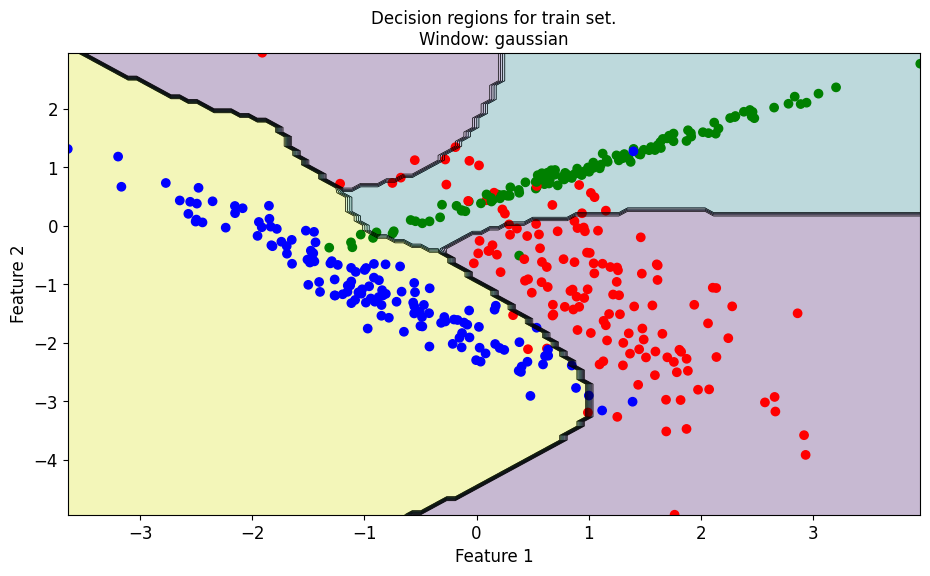

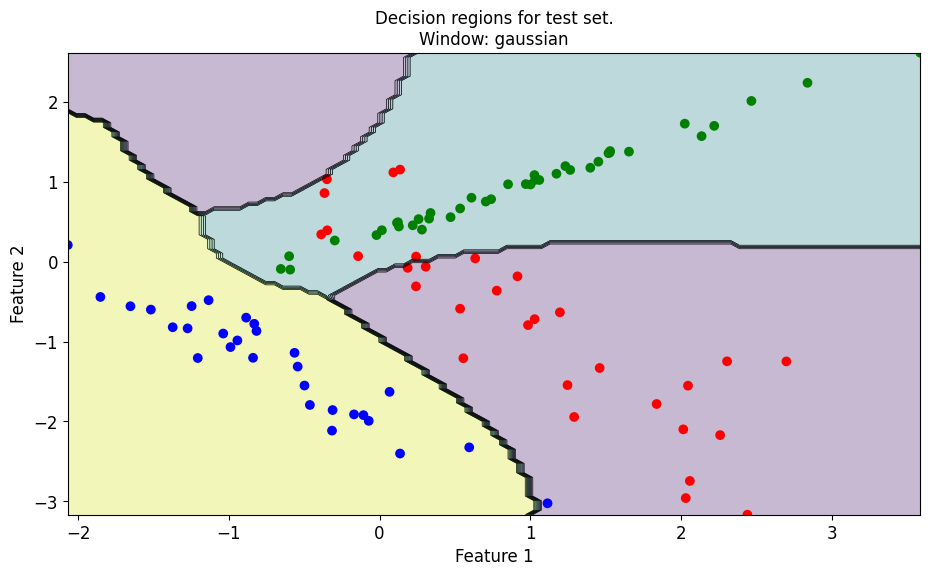

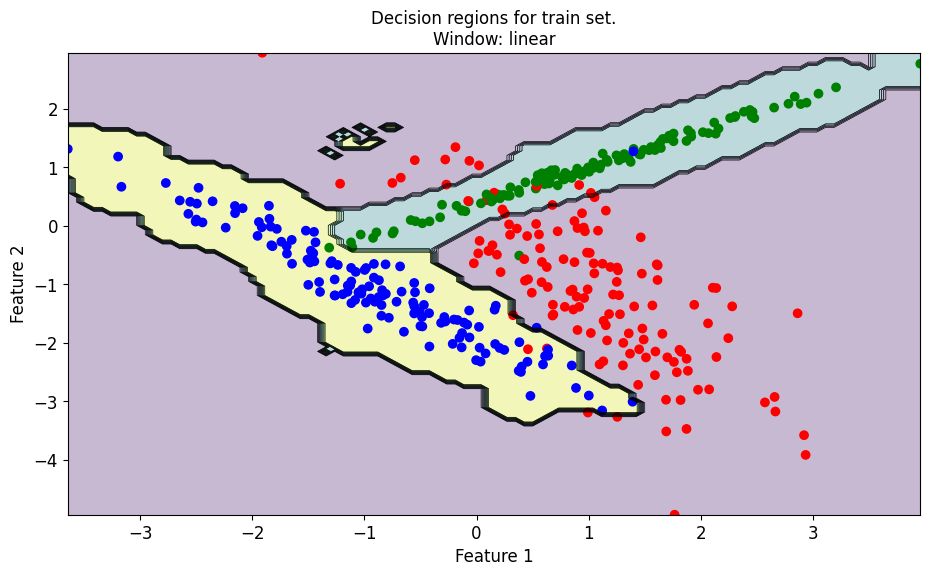

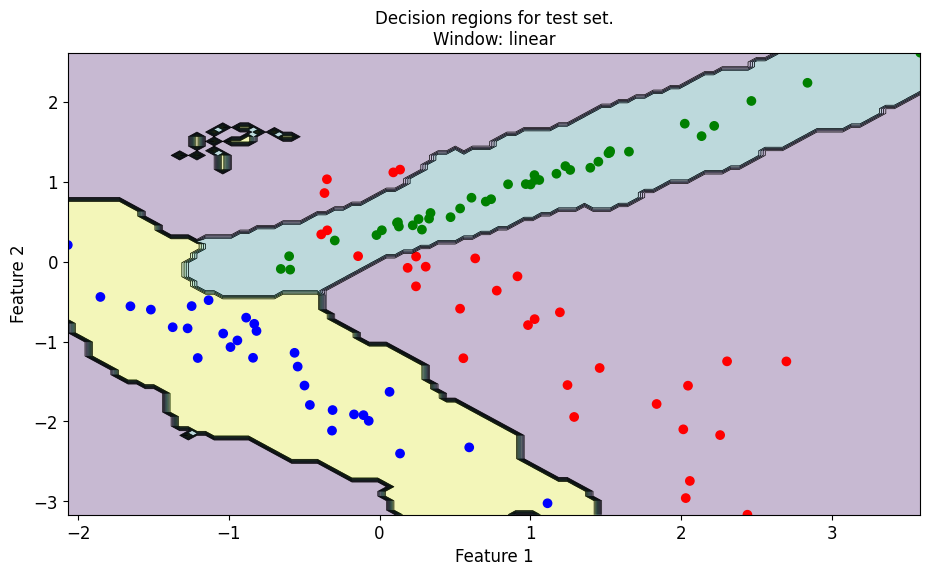

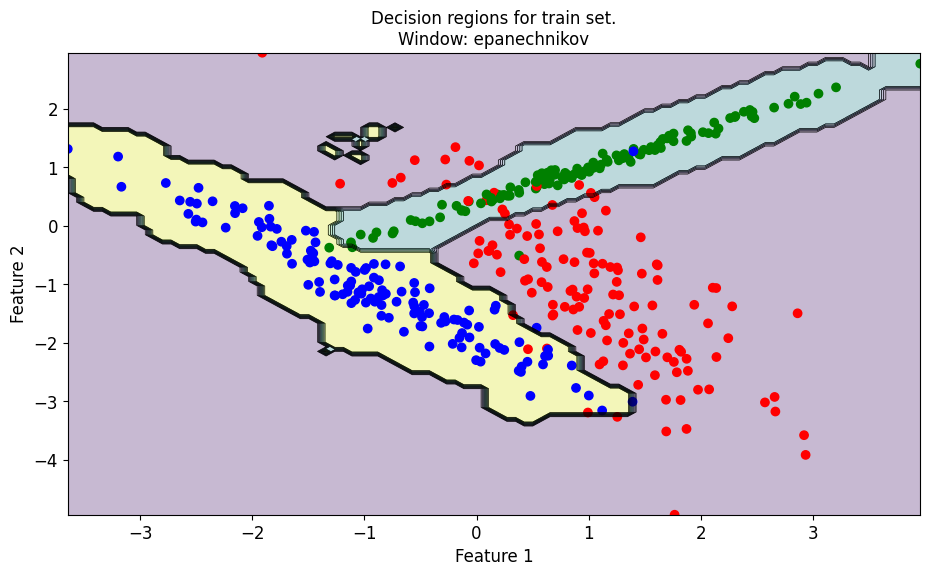

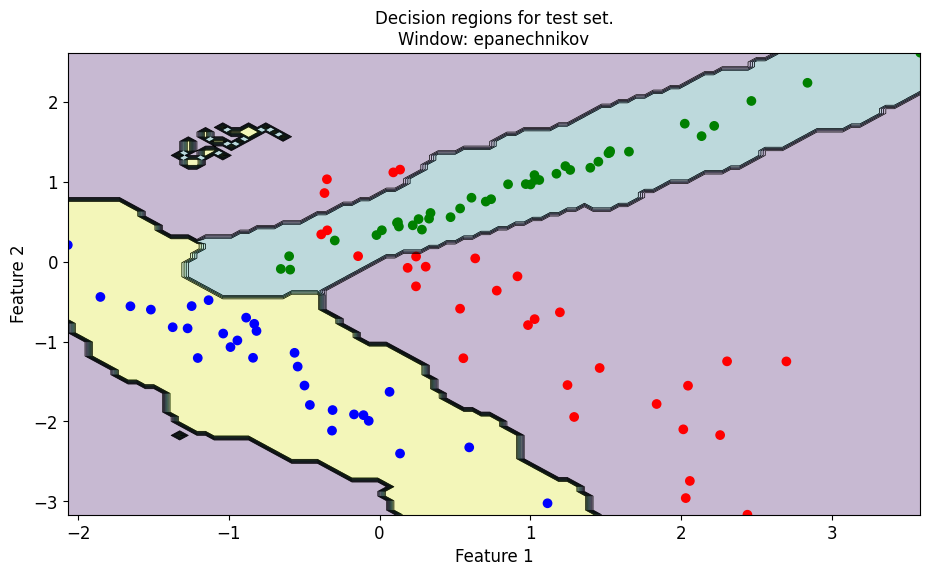

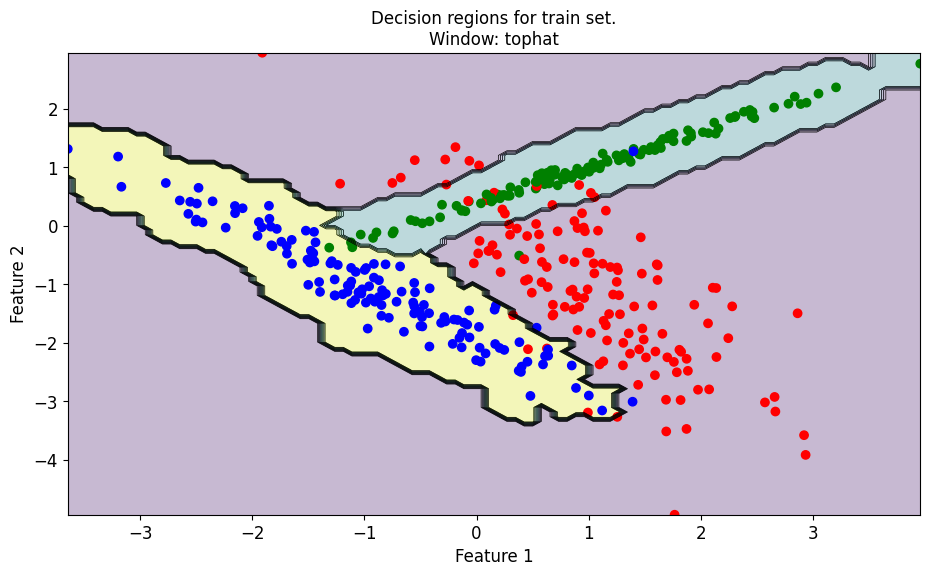

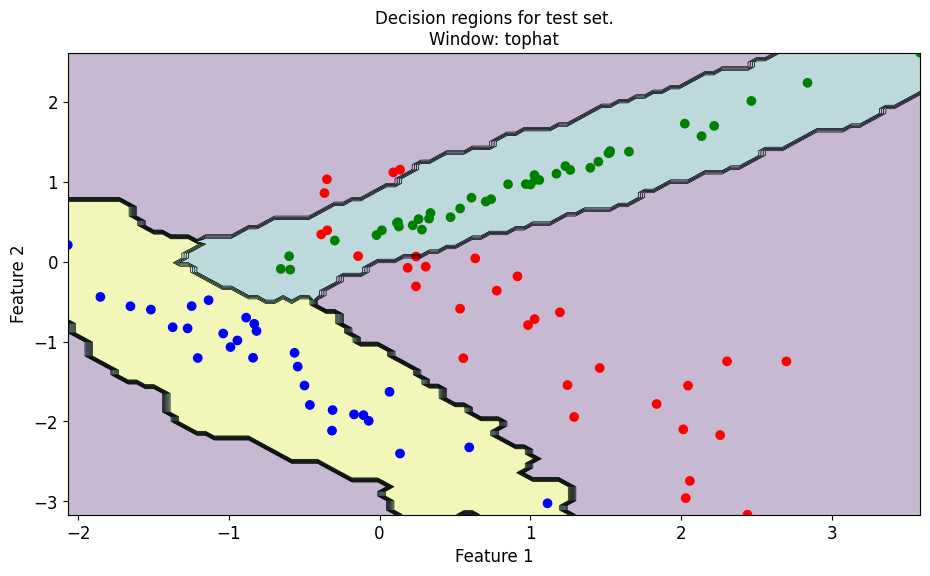

In [ ]:
windows = ["gaussian", "linear", "epanechnikov", "tophat"]
n_point = 100

for wd in windows:
    classifier = KernelDensityClassifier(kernel=wd, bandwidth="silverman")
    classifier.fit(X_train, y_train)

    m = np.meshgrid(
        np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), n_point),
        np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), n_point),
    )
    m_labels = classifier.predict(np.vstack((np.ravel(m[0]), np.ravel(m[1]))).T)
    m_labels = m_labels.reshape(m[0].shape)

    plt.figure()
    # plt.contourf(m[0], m[1], m_labels, alpha=0.3, cmap=plt.cm.Paired)
    plt.contourf(m[0], m[1], m_labels, alpha=0.3)

    plt.contour(m[0], m[1], m_labels, colors="k", linewidths=0.5)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=colors[y_train])
    plt.title(f"Decision regions for train set.\nWindow: {wd}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

    m = np.meshgrid(
        np.linspace(np.min(X_test[:, 0]), np.max(X_test[:, 0]), n_point),
        np.linspace(np.min(X_test[:, 1]), np.max(X_test[:, 1]), n_point),
    )
    m_labels = classifier.predict(np.vstack((np.ravel(m[0]), np.ravel(m[1]))).T)
    m_labels = m_labels.reshape(m[0].shape)

    plt.figure()
    plt.contourf(m[0], m[1], m_labels, alpha=0.3)

    # Добавляем границы между классами
    plt.contour(m[0], m[1], m_labels, colors="k", linewidths=0.5)

    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors[y_test])
    plt.title(f"Decision regions for test set.\nWindow: {wd}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

***>>> TASK 5***

In [ ]:
# Functions that are used for task 5


def count_cmatrix(y, y_pred):
    """
    This function receives label and labels_pred as input, and outputs a list of scores.
    It contains N lists (N is the number of classes in the sample).
    Using, for example, scores[n], you can get the matrix parameters for a certain class.

    Parameters in score are located like: tp fn fp tn
    Needs
        "from sklearn.metrics import confusion_matrix"
        "import numpy as np"
    to work.
    """
    # Create confusion matrix and scores list
    scores = []
    matrix = confusion_matrix(y, y_pred)

    # Calculate number of classes
    num_classes = len(np.unique(y))

    # Matrix based scores
    # Positive answers
    tp = []
    fn = []

    # Negative answers
    tn = []
    fp = []

    # Calculation for One-vs-All
    for item in range(num_classes):
        numbers = []
        tp = 0
        tp = matrix[item][item]
        numbers.append(tp)
        fn = 0
        for col in range(num_classes):
            if col == item:
                continue
            else:
                fn += matrix[item][col]
        numbers.append(fn)
        fp = 0
        for row in range(num_classes):
            if row == item:
                continue
            else:
                fp += matrix[row][item]
        numbers.append(fp)
        tn = 0
        for row in range(num_classes):
            for col in range(num_classes):
                if row == item or col == item:
                    continue
                else:
                    tn += matrix[row][col]
        numbers.append(tn)
        scores.append(numbers)
    return scores


def matrix_based_val(y, y_pred, number_of_class=0):
    tp, fn, fp, tn = count_cmatrix(y, y_pred)[number_of_class]
    p, n = tp + fn, fp + tn
    acc = (tp + tn) / (p + n)
    err = (fp + fn) / (p + n)
    sens = tp / p
    spec = tn / n
    prec = tp / (tp + fp)
    F1 = 2 * prec * sens / (prec + sens)

    print(
        f"""
    >>> Accuracy: {acc}
    >>> Error: {err}
    >>> Sensitivity: {sens}
    >>> Specificity: {spec}
    >>> Precision: {prec}
    >>> Recall: {sens}
    >>> F1-score: {F1}"""
    )


def tprs_fprs_precs(
    X, y, classifier=classifier, number_of_class=0, thresholds_number=1000
):
    """
    This function calculater metrics
    to plot ROC and PR curves by hand.

    Requires prefit clissifier to work!
    If you have it in your code and it's called classifier - OK,
    Else - add your classifier name to arguments.

    Input:
        Expected: data frame (array), labels column (array)
        Optional: name of classifier, number_of_class (if multicalss), thresholds number
    Output: three values - tprs, fprs, precs
    """
    thresholds = np.linspace(0.0, 1.0, thresholds_number)

    tprs, fprs, precs = [], [], []

    # probs = classifier.predict_proba(X)
    # scores = probs[:,1]

    for th in thresholds:
        # y_pred = (scores > th).astype(int) * 2 - 1
        y_pred = classifier.predict(X)

        tp, fn, fp, tn = count_cmatrix(y, y_pred)[number_of_class]

        tpr = tp / (tp + fn) if tp + fn > 0 else np.nan
        fpr = fp / (tn + fp) if tn + fp > 0 else np.nan
        prec = tp / (tp + fp) if tp + fp > 0 else np.nan

        tprs.append(tpr)
        fprs.append(fpr)
        precs.append(prec)

    tprs = np.array(tprs)
    fprs = np.array(fprs)
    precs = np.array(precs)

    return tprs, fprs, precs


def plot_roc(tprs, fprs):
    plt.figure()
    plt.plot(fprs, tprs)
    plt.show()


def plot_pr(tprs, precs):
    plt.figure()
    plt.plot(tprs, precs)
    plt.show()


def plot_matrix(y, y_pred):
    fig, ax = plt.subplots()
    matrix = confusion_matrix(y, y_pred)
    cmp = ConfusionMatrixDisplay(matrix)
    plt.figure()
    cmp.plot(ax=ax)
    plt.show()

In [ ]:
def binarize_labels(y):
    binarized_labels = []
    num_classes = len(np.unique(y))
    for cls in range(num_classes):
        # Бинаризуем коллонку слассов
        y_bin = []
        for idx in range(len(y)):
            if y[idx] == cls:
                y_bin.append(1)
            else:
                y_bin.append(0)
        binarized_labels.append(y_bin)
    binarized_labels = np.array(binarized_labels).T
    return binarized_labels


def mcroc(
    X, y, classifier=classifier, kernel="gaussian", bandwidth="silvermal"
):  # Multiclass ROC
    num_classes = len(np.unique(y))
    y_bin = binarize_labels(y)  # Три столбика
    for cls in range(num_classes):
        # Сплитим
        X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(
            X, y_bin[cls], test_size=0.2, random_state=42
        )
        clf = classifier.fit(X_bin_train, y_bin_train)
        scores = clf.predict_proba(X_bin_test)
        # scores = probs
        # score = scores[:,cls]
        # y_pred = (score > th).astype(int) * 2 - 1
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for cls in range(num_classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test[:, cls], scores[:, cls])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Plot of a ROC curve for a specific class
    for cls in range(num_classes):
        plt.figure()
        plt.plot(fpr[cls], tpr[cls], label="ROC curve (area = %0.2f)" % roc_auc[cls])
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic example")
        plt.legend(loc="lower right")
        plt.show()

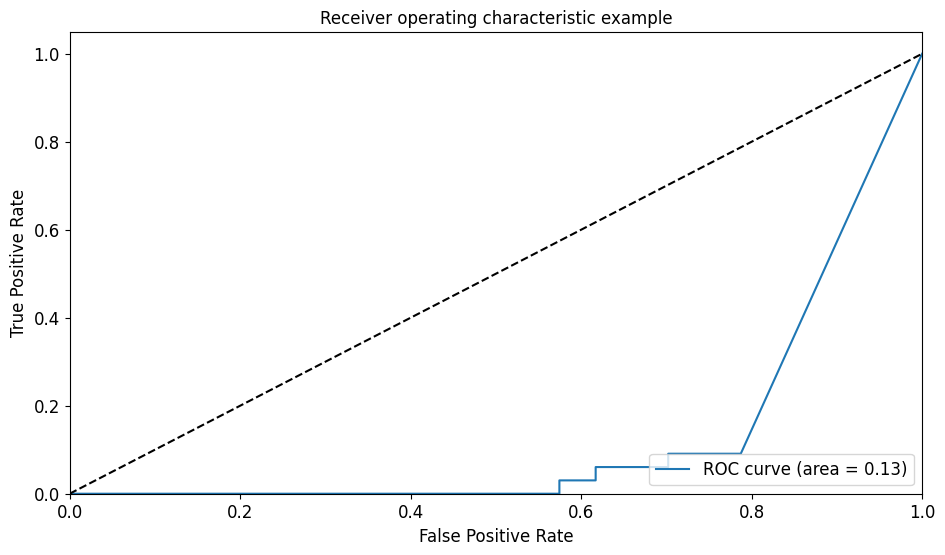

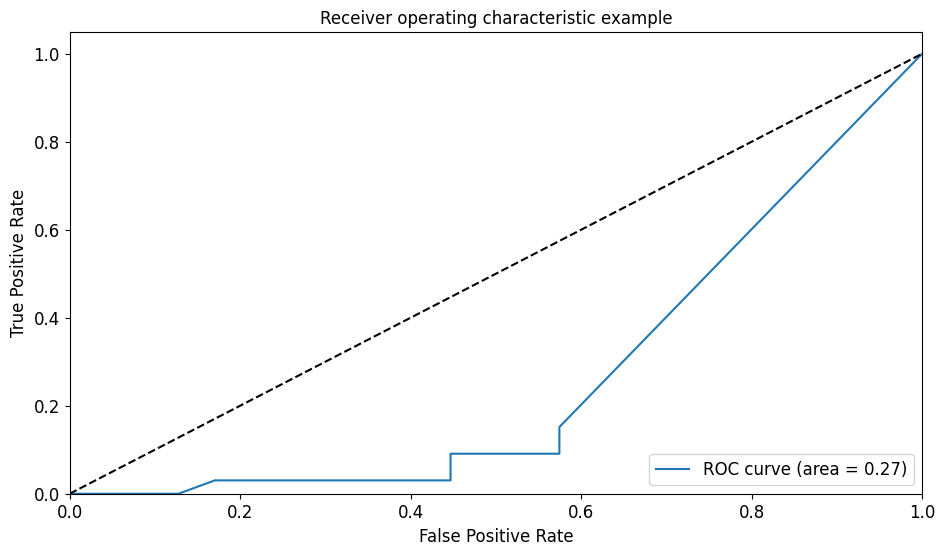

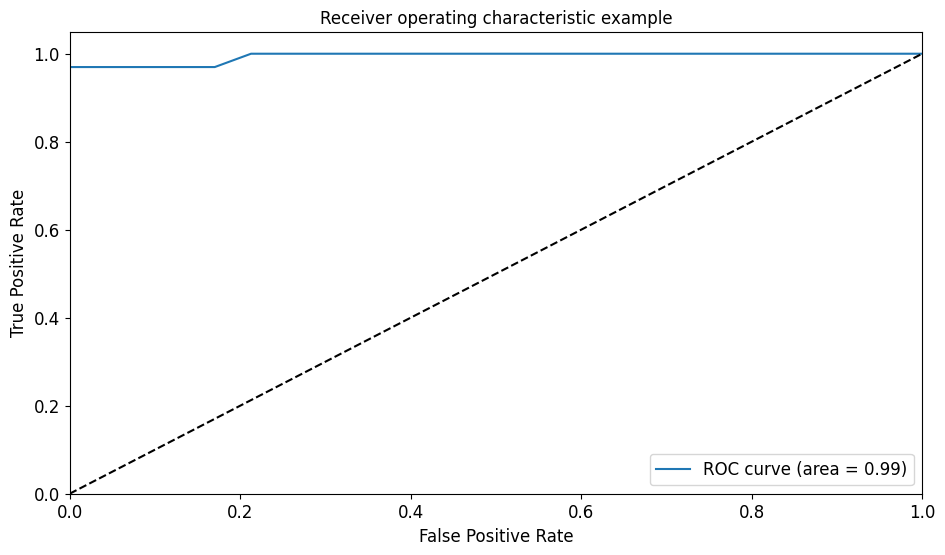

In [ ]:
def mcroc(
    X, y, classifier=classifier, kernel="gaussian", bandwidth="silvermal"
):  # Multiclass ROC
    num_classes = len(np.unique(y))
    y_bin = binarize_labels(y)  # Три столбика
    classifier.fit(X, y)
    for cls in range(num_classes):
        # Сплитим
        X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(
            X, y_bin[:, cls], test_size=0.2, random_state=42
        )
        scores = classifier.predict_proba(X_bin_test)
        # scores = probs
        # score = scores[:,cls]
        # y_pred = (score > th).astype(int) * 2 - 1
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for cls in range(num_classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_bin_test, scores[:, cls])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Plot of a ROC curve for a specific class
    for cls in range(num_classes):
        plt.figure()
        plt.plot(fpr[cls], tpr[cls], label="ROC curve (area = %0.2f)" % roc_auc[cls])
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic example")
        plt.legend(loc="lower right")
        plt.show()


kernel = "gaussian"
bandwidth = 0.16080402

mcroc(X_train, y_train, kernel=kernel, bandwidth=bandwidth)

**>>> TASK 6**


In [27]:
# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
# Train classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [29]:
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Print accuracies on training and test samples
print(f">>> Accuracy on training set: {round(gnb.score(X_train, y_train), 2)}")
print(f">>> Accuracy on test set: {round(gnb.score(X_test, y_test), 2)}")

>>> Accuracy on training set: 0.84
>>> Accuracy on test set: 0.86


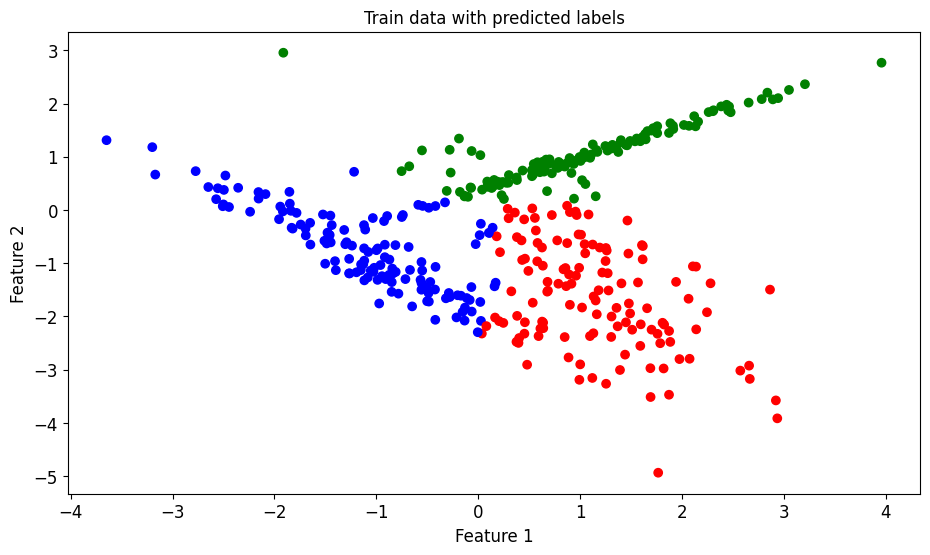

In [30]:
# Plot predicted labels data
plt.figure()
plt.title("Train data with predicted labels")
plt.scatter(X_train[:, 0], X_train[:, 1], c=colors[y_train_pred])
# plt.xlim([-3.5,5])
# plt.ylim([-5,2.5])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(False)

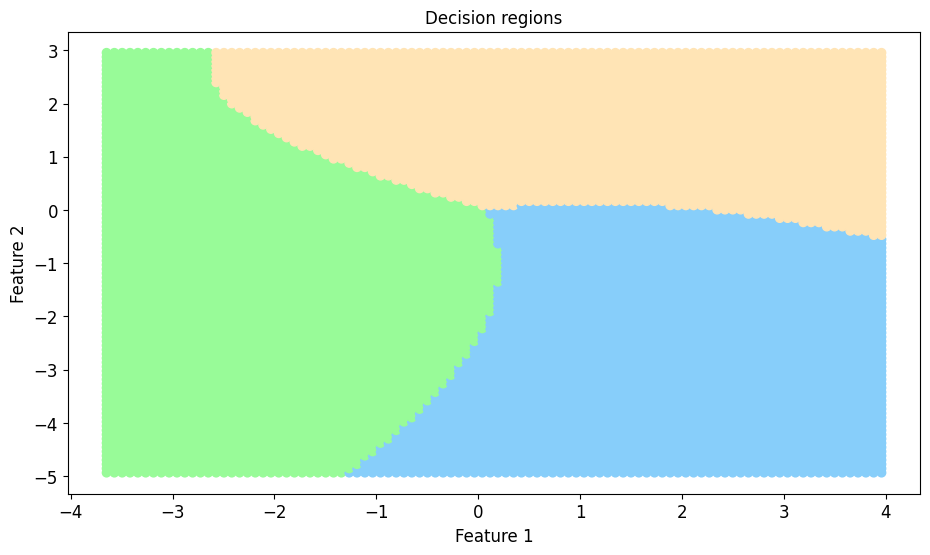

In [31]:
# Plot decision regions
regions_colors = np.array(["lightskyblue", "moccasin", "palegreen"])
n_point = 100
m = np.meshgrid(
    np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), n_point),
    np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), n_point),
)
m_labels = gnb.predict(np.vstack((np.ravel(m[0]), np.ravel(m[1]))).T)

plt.figure()
plt.title("Decision regions")
plt.scatter(m[0], m[1], c=regions_colors[m_labels])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

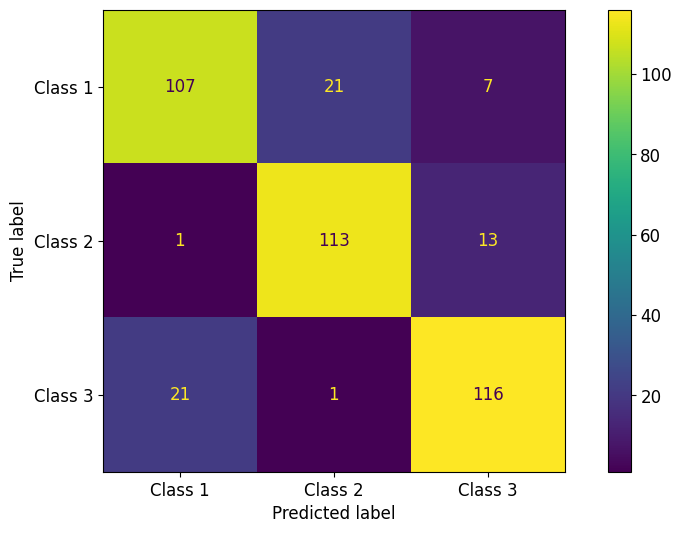

<Figure size 1100x600 with 0 Axes>

In [32]:
# Confusion matrix
fig, ax = plt.subplots()
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_train_pred),
    display_labels=["Class 1", "Class 2", "Class 3"],
)
plt.figure()
cmp.plot(ax=ax)
plt.show()

In [39]:
scores = cross_val_score(gnb, X_test, y_test, cv=5)
print(
    "%0.2f mean accuracy with a standard deviation of %0.2f"
    % (scores.mean(), scores.std())
)

0.84 mean accuracy with a standard deviation of 0.04


In [40]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
scores = cross_val_score(lgr, X_test, y_test, cv=5)
print(
    "%0.2f mean accuracy with a standard deviation of %0.2f"
    % (scores.mean(), scores.std())
)

0.90 mean accuracy with a standard deviation of 0.03
